# UNFINISHED - Multi-task learning

Can we fit a model to multiple targets to improve performance on a tabular learning example?

Todo:
1. Download data and process
   1. Weather dataset - https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data?resource=download
      1. Predict the temperature in one city based on its historic weather
      2. Predict the temperature of multiple cities at once
      3. Predict multiple weather signals in one/multiple cities
   2. Retail dataset
2. Build base learners
   1. GBM
   2. Dense neural network
3. Build multi task learners
   1. Shared layers, with split layers per task
4. Explore the combination of metrics

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl

plt.style.use("seaborn-v0_8-whitegrid")
pl.Config.set_fmt_str_lengths(30)

polars.config.Config

## Load data

In [2]:
df = pl.read_csv("data/weather/temperature.csv")
df = df.with_columns(
    pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"),
    pl.exclude("datetime") - 273.15,  # convert from Kelvin to Celcius
)
display(df.shape, df.head())

df.describe()

(45253, 37)

datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,San Antonio,Dallas,Houston,Kansas City,Minneapolis,Saint Louis,Chicago,Nashville,Indianapolis,Atlanta,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2012-10-01 12:00:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,35.95,null,null,null
2012-10-01 13:00:00,11.48,8.93,16.33,8.65,18.72,18.38,20.26,23.45,11.97,11.46,16.14,16.59,15.12,16.83,13.72,13.03,10.86,14.26,10.7,20.88,10.88,25.02,15.5,26.57,7.85,13.11,12.48,15.07,12.68,14.02,34.44,32.32,37.43,31.25,31.25,30.35
2012-10-01 14:00:00,11.479041,8.933252,16.324993,8.647217,18.718186,18.383501,20.253141,23.458509,12.004558,11.457306,16.153649,16.612974,15.147576,16.847635,13.743636,13.035246,10.904691,14.27136,10.739394,20.885341,10.919789,25.05523,15.500172,26.582518,7.874767,13.112541,12.513208,15.097676,12.68465,14.036092,34.44,31.16,37.345769,31.25,31.25,30.35
2012-10-01 15:00:00,11.476998,8.941866,16.310618,8.639833,18.712844,18.393355,20.242177,23.481487,12.083952,11.449918,16.188497,16.680767,15.184343,16.888151,13.801401,13.049194,11.027412,14.304637,10.791919,20.899702,11.023965,25.149595,15.500582,26.616579,7.938319,13.119518,12.606824,15.17694,12.69779,14.081672,34.241513,31.131841,37.261538,31.25,31.25,30.35
2012-10-01 16:00:00,11.474955,8.950481,16.296243,8.632449,18.707503,18.403209,20.231213,23.504466,12.163345,11.44253,16.223345,16.74856,15.221111,16.928666,13.859166,13.063142,11.150133,14.337914,10.844444,20.914063,11.12814,25.243961,15.500991,26.650641,8.00187,13.126496,12.70044,15.256203,12.710929,14.127251,33.9952,31.088015,37.177308,31.25,31.25,30.35


statistic,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,San Antonio,Dallas,Houston,Kansas City,Minneapolis,Saint Louis,Chicago,Nashville,Indianapolis,Atlanta,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""45253""",44458.0,45252.0,44460.0,45250.0,45250.0,45252.0,45252.0,45250.0,45252.0,45252.0,45252.0,45249.0,45250.0,45252.0,45240.0,45252.0,45250.0,45251.0,45246.0,45247.0,45252.0,45252.0,45250.0,44448.0,45250.0,45252.0,45250.0,44460.0,45250.0,45250.0,44455.0,44460.0,44461.0,44455.0,44456.0,44460.0
"""null_count""","""0""",795.0,1.0,793.0,3.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0,4.0,3.0,1.0,13.0,1.0,3.0,2.0,7.0,6.0,1.0,1.0,3.0,805.0,3.0,1.0,3.0,793.0,3.0,3.0,798.0,793.0,792.0,798.0,797.0,793.0
"""mean""","""2015-05-02 06:00:00""",10.712654,11.842929,15.005821,11.259626,17.696116,17.065044,19.274887,22.343358,12.467856,9.689407,20.635646,19.225872,21.054268,13.491663,7.550489,13.525947,10.200573,15.416306,11.621904,16.622673,9.821668,21.18338,15.747483,25.031274,10.903939,8.791241,12.224168,12.250406,7.19301,10.629823,18.371986,21.362307,23.347276,22.116398,20.944803,20.034253
"""std""",null,6.640131,7.452438,5.332862,6.547986,6.460823,5.889992,10.829522,9.916743,9.853484,10.673464,8.303688,9.464741,7.766719,11.169761,12.774979,10.938867,10.997137,9.88359,11.043634,8.703643,11.034481,6.682162,9.133072,4.190185,10.453927,10.547226,10.242377,10.220932,11.953626,9.802499,7.821815,6.676412,8.852984,6.324566,6.304118,7.093583
"""min""","""2012-10-01 12:00:00""",-28.0,-10.78,-0.85,-9.37,-6.646333,-7.366667,-12.588667,-7.091,-18.107667,-25.422333,-8.1,-11.539667,-5.58,-23.593667,-30.813333,-22.1,-24.26,-16.823667,-28.283667,-13.65,-29.666667,-4.54,-17.491667,2.083333,-23.727333,-25.85,-22.76,-22.376,-29.85,-23.61,-0.971,-2.101,-2.0,-2.0,-4.468,-0.176
"""25%""","""2014-01-15 21:00:00""",6.01,6.7,11.52,6.68,13.23,13.105,10.77,14.53,4.82,1.91,15.45,12.57,16.211,5.15,-1.36,5.11,2.022333,8.07,2.96,10.1705,1.54,16.891,8.86,22.88,2.707014,1.11,4.200348,4.22,-1.18,2.94,12.217246,16.3,16.584,17.317333,16.732,14.374304
"""50%""","""2015-05-02 06:00:00""",10.3,11.17,14.46,10.79,17.38,16.97,18.879973,22.437667,12.97,9.821333,22.035,20.413,22.51,14.912,8.489,14.6195,10.791,16.820333,12.78,17.9,10.39,22.49,16.97,25.73,12.07,9.2,12.777667,12.72,7.959,10.984,17.782667,21.75,23.0,21.67,21.0,19.8465
"""75%""","""2016-08-15 15:00:00""",15.451047,16.3,17.864667,15.38,21.93,20.9575,27.684667,29.9,19.685357,17.53,26.34,26.4,26.54,22.48,18.16,22.41,19.13,22.9905,20.81,23.14,19.08,25.99,22.62,27.842333,19.43,17.509333,20.646,20.61,17.22,18.47,24.12,26.65,30.0,26.51,25.78,26.0
"""max""","""2017-11-30 00:00:00""",33.85,39.37,40.47,34.15,42.32,40.21,45.49,48.07,39.56,40.6,40.51,41.25,39.76,37.82,35.09,38.44,35.33,36.0,38.89,37.61,34.9,37.0,37.75,35.53,33.14,34.13,34.85,37.09,34.73,34.85,41.67,47.78,47.0,47.78,40.0,43.89


## Exploring data

One city

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/1793961453.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


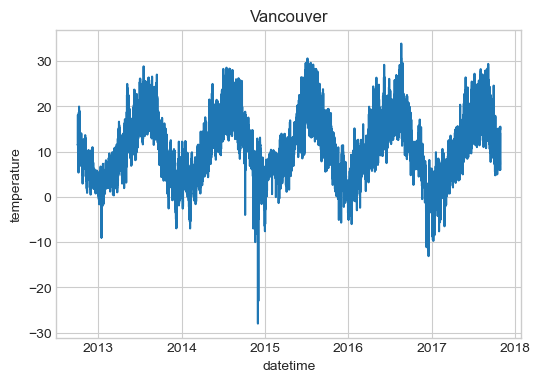

In [3]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=df, x="datetime", y="Vancouver", ax=ax)
ax.set(title="Vancouver", ylabel="temperature")
fig.show()

Multiple cities, plotting per day

We see correlation between cities, therefore we should be able to learn these in combination.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/1983877762.py:2: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  df.with_columns(pl.col("datetime").dt.date())
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/1983877762.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


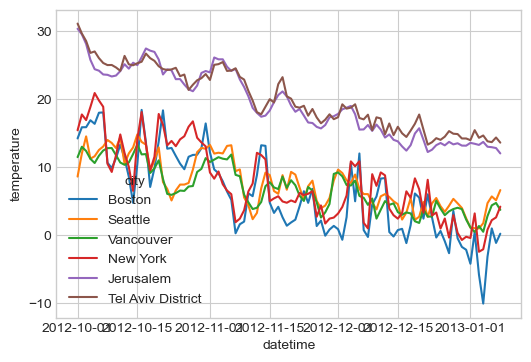

In [4]:
plot_df = (
    df.with_columns(pl.col("datetime").dt.date())
    .select(
        [
            "datetime",
            "Boston",
            "Seattle",
            "Vancouver",
            "New York",
            "Jerusalem",
            "Tel Aviv District",
        ]
    )
    .group_by("datetime")
    .mean()
    .sort("datetime")
    .head(100)
    .melt(id_vars=["datetime"], variable_name="city", value_name="temperature")
)
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=plot_df, x="datetime", y="temperature", hue="city", ax=ax)
fig.show()

## Cluster cities

If we group cities based on location these could be appropriate to model together.

In [5]:
import math


def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = (
        math.sin(delta_phi / 2) ** 2
        + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance


df_city_attributes = pl.read_csv("data/weather/city_attributes.csv")
df_city_distances = (
    df_city_attributes.join(df_city_attributes, on="City", how="cross")
    .with_columns(
        [
            pl.struct(["Latitude", "Longitude", "Latitude_right", "Longitude_right"])
            .map_elements(
                lambda x: haversine_distance(
                    x["Latitude"],
                    x["Longitude"],
                    x["Latitude_right"],
                    x["Longitude_right"],
                )
            )
            .alias("distance")
        ]
    )
    .select(pl.col(["City", "City_right", "distance"]))
    .pivot(index="City", on="City_right", values="distance")
)
df_city_distances

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/3188131027.py:24: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .with_columns(


City,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,San Antonio,Dallas,Houston,Kansas City,Minneapolis,Saint Louis,Chicago,Nashville,Indianapolis,Atlanta,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Vancouver""",0.0,415.674489,1277.164186,191.750571,1736.802861,1903.910689,1591.24411,1979.408477,2069.959874,1777.718595,3030.04286,2842.297031,3186.322396,2519.973107,2292.69167,2859.236551,2852.390016,3264.410646,3078.490002,3603.428255,3160.970485,4048.690561,3752.318276,4508.999587,3485.919116,3354.51642,3864.702826,3904.480845,3685.252583,4024.912453,10799.977317,10710.588045,10986.194816,10636.025824,10617.894518,10754.089353
"""Portland""",415.674489,0.0,861.858892,233.081256,1330.013512,1500.709163,1216.357085,1618.752934,1781.239238,1579.390451,2765.932219,2624.358454,2951.41219,2404.119356,2290.280051,2767.017841,2822.991473,3162.643198,3027.08417,3490.253785,3161.093936,3920.254611,3677.172965,4352.685772,3475.702891,3388.703824,3871.727105,3925.252473,3763.297665,4076.115269,11180.358111,11091.626356,11365.650496,11018.061979,11000.315739,11135.886957
"""San Francisco""",1277.164186,861.858892,0.0,1093.211566,559.122434,737.870657,670.713624,1050.816541,1440.217535,1524.981872,2393.798288,2382.152109,2643.464961,2419.862066,2545.066807,2802.660317,2983.392088,3151.681446,3129.951497,3436.894559,3358.889733,3814.273955,3696.507584,4168.921456,3637.229761,3640.695396,4050.512659,4129.056245,4082.594924,4333.630766,11983.377759,11896.066468,12166.53052,11824.52699,11807.539288,11941.682846
"""Seattle""",191.750571,233.081256,1093.211566,0.0,1545.30299,1712.17428,1402.191793,1793.580288,1903.883499,1641.115633,2873.924629,2702.186095,3040.679004,2418.544574,2239.01503,2768.586692,2788.662837,3170.744403,3005.75752,3505.681744,3111.164497,3945.363998,3670.756202,4394.977815,3432.174561,3320.639709,3819.371941,3865.451699,3672.497974,4000.084448,10953.312437,10864.367773,11138.912563,10790.488567,10772.62278,10908.395674
"""Los Angeles""",1736.802861,1330.013512,559.122434,1545.30299,0.0,179.646857,368.137179,574.260945,1067.025725,1335.947982,1933.761792,1990.973031,2206.759438,2179.519715,2448.654036,2552.556421,2801.876308,2858.810956,2906.147127,3110.333122,3185.369594,3449.428227,3403.773794,3758.043104,3431.368421,3492.129828,3843.572755,3935.735755,3965.42761,4169.54344,12223.162447,12138.693066,12401.753349,12070.937277,12055.323525,12186.325497
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Tel Aviv District""",10710.588045,11091.626356,11896.066468,10864.367773,12138.693066,12232.034459,11805.09725,11943.99505,11531.585274,11018.121769,11585.304932,11195.586584,11360.082705,10531.706021,9969.680446,10313.882599,9907.30113,10293.126477,9977.205922,10316.530787,9592.373043,10374.441126,9963.870837,10590.765747,9535.033612,9268.723738,9245.529714,9116.282323,8779.273877,8810.589337,92.464246,0.0,281.154435,83.332771,106.219981,52.584202
"""Eilat""",10986.194816,11365.650496,12166.53052,11138.912563,12401.753349,12492.436399,12065.557168,12197.115442,11777.737598,11267.819359,11806.493585,11420.126472,11575.465868,10764.382212,10210.86815,10538.523569,10134.687475,10506.511743,10197.798942,10519.649543,9814.051935,10563.098281,10164.376687,10762.995622,9747.616937,9488.499392,9449.444524,9320.569074,8995.96142,9015.309368,188.937637,281.154435,0.0,362.239416,383.629262,247.184318
"""Haifa""",10636.025824,11018.061979,11824.52699,10790.488567,12070.937277,12165.535696,11738.617032,11880.835865,11471.486428,10956.578367,11535.166034,11144.240637,11312.189363,10477.289384,9911.891058,10262.667823,9855.090195,10246.214038,9927.620322,10273.422329,9542.445414,10336.537323,9921.801347,105

Cluster cities

/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/3130400948.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


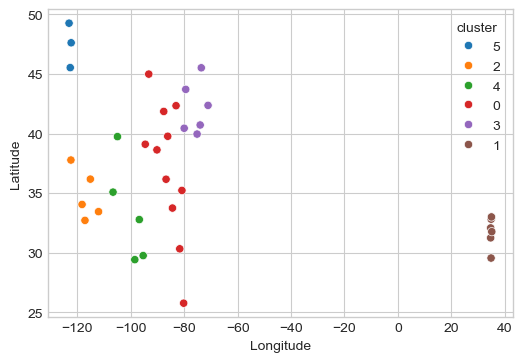

In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(df_city_distances[:,1:].to_numpy())
df_city_attributes = df_city_attributes.with_columns(pl.lit(clusters).alias('cluster'))

fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=df_city_attributes.with_columns(pl.col("cluster").cast(str)),
    x="Longitude",
    y="Latitude",
    hue="cluster",
    ax=ax,
)
fig.show()

## Building models

Helper functions

In [7]:
import pytorch_lightning as pyl
from pytorch_lightning.callbacks import EarlyStopping
import torch
import torch.nn as nn
from typing import List, Dict


def create_lags(df: pl.DataFrame, columns: List[str], lags: List[int]) -> pl.DataFrame:
    df = df.with_columns(
        [
            pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")
            for lag in lags
            for col in columns
        ]
    )
    df = df.drop_nulls()
    return df


def get_features_from_outcomes(df: pl.DataFrame, outcome_cols: List[str]) -> List[str]:
    feature_cols = [
        col
        for col in df.columns
        for outcome_col in outcome_cols
        if f"{outcome_col}_lag_" in col
    ]
    return feature_cols


def dataloader_from_df(
    df: pl.DataFrame, feature_cols: List[str], outcome_cols: List[str]
) -> torch.utils.data.DataLoader:
    dataset = torch.utils.data.TensorDataset(
        torch.Tensor(df[feature_cols].to_numpy()),
        torch.Tensor(df[outcome_cols].to_numpy()),
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=2**10, shuffle=True)
    return dataloader


def plot_training_logs(model):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(np.array(model.log_train), label="train_LL")
    ax.plot(np.array(model.log_val), label="test_LL")
    ax.set(xlabel="Step", ylabel="Logloss")
    ax.legend()
    fig.show()


def calculate_loss(
    model, outcome_cols: List[str], dataloader: torch.utils.data.DataLoader
) -> List[Dict]:
    y_est_y = [[model(x), y] for x, y in dataloader]
    y_est = torch.concat([y_est for y_est, y in y_est_y], dim=0)
    y = torch.concat([y for y_est, y in y_est_y], dim=0)

    return [
        {"col": col, "mse": nn.MSELoss()(y[:, idx], y_est[:, idx]).item()}
        for idx, col in enumerate(outcome_cols)
    ]


def get_predictions(
    df: pl.DataFrame, model, feature_cols: List[str], outcome_cols: List[str]
) -> pl.DataFrame:
    y_est = model(torch.Tensor(df[feature_cols].to_numpy()))
    return pl.concat(
        [
            df,
            pl.DataFrame(
                y_est.detach().numpy(),
                schema=[f"{outcome_col}_est" for outcome_col in outcome_cols],
            ),
        ],
        how="horizontal",
    )


def plot_predictions(df_train_est, df_test_est, outcome_cols):
    for outcome_col in outcome_cols:
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(
            data=df_train_est.melt(
                id_vars=["datetime"], value_vars=[outcome_col, f"{outcome_col}_est"]
            ),
            x="datetime",
            y="value",
            hue="variable",
            ax=ax,
        )
        sns.lineplot(
            data=df_test_est.melt(
                id_vars=["datetime"], value_vars=[outcome_col, f"{outcome_col}_est"]
            ),
            x="datetime",
            y="value",
            hue="variable",
            ax=ax,
            legend=None,
        )
        ax.axvline(
            x=df_test_est["datetime"].min(), linestyle="--", color="k", alpha=0.5
        )
        ax.set(title=outcome_col)
        ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))


def loss_from_outcomes(
    model_callable,
    outcome_cols: List[str],
    feature_cols: List[str] = None,
    debug: bool = False,
    seed: int = None,
    df_train=None,
    df_test=None,
    df=None,
    epochs: int = 200,
):
    if df_train is None:
        # limited train data to make the problem hard
        df_train = df[: int(df.shape[0] * 0.5)].sample(fraction=0.01, seed=0)
        df_test = df[int(df.shape[0] * 0.5) :]

    if feature_cols is None:
        feature_cols = get_features_from_outcomes(df_train, outcome_cols)

    if seed is not None:
        torch.manual_seed(seed)
    dataloader_train = dataloader_from_df(df_train, feature_cols, outcome_cols)
    dataloader_test = dataloader_from_df(df_test, feature_cols, outcome_cols)

    model = model_callable(
        feature_cols,
        outcome_cols,
    )

    early_stopping = EarlyStopping(
        monitor="train_loss",
        min_delta=0.1,
        patience=10,
        verbose=False,
    )

    trainer = pyl.Trainer(
        max_epochs=epochs,
        accelerator="mps",
        enable_progress_bar=debug,
        enable_model_summary=debug,
        callbacks=[early_stopping],
    )
    trainer.fit(model, dataloader_train)

    if debug:
        plot_training_logs(model)

    loss_train = calculate_loss(model, outcome_cols, dataloader_train)
    loss_test = calculate_loss(model, outcome_cols, dataloader_test)

    df_train_est = get_predictions(df_train, model, feature_cols, outcome_cols)
    df_test_est = get_predictions(df_test, model, feature_cols, outcome_cols)

    if debug:
        plot_predictions(df_train_est, df_test_est, outcome_cols)

    return loss_train, loss_test

In [8]:
lags = [24, 48, 72, 96]
df_lagged = create_lags(df, columns=df.columns[1:], lags=lags)
df_lagged

datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,San Antonio,Dallas,Houston,Kansas City,Minneapolis,Saint Louis,Chicago,Nashville,Indianapolis,Atlanta,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem,…,Jerusalem_lag_72,Vancouver_lag_96,Portland_lag_96,San Francisco_lag_96,Seattle_lag_96,Los Angeles_lag_96,San Diego_lag_96,Las Vegas_lag_96,Phoenix_lag_96,Albuquerque_lag_96,Denver_lag_96,San Antonio_lag_96,Dallas_lag_96,Houston_lag_96,Kansas City_lag_96,Minneapolis_lag_96,Saint Louis_lag_96,Chicago_lag_96,Nashville_lag_96,Indianapolis_lag_96,Atlanta_lag_96,Detroit_lag_96,Jacksonville_lag_96,Charlotte_lag_96,Miami_lag_96,Pittsburgh_lag_96,Toronto_lag_96,Philadelphia_lag_96,New York_lag_96,Montreal_lag_96,Boston_lag_96,Beersheba_lag_96,Tel Aviv District_lag_96,Eilat_lag_96,Haifa_lag_96,Nahariyya_lag_96,Jerusalem_lag_96
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2012-10-05 13:00:00,5.42,10.38,15.45,7.99,17.1,17.78,20.92,21.42,12.14,3.78,22.7,18.85,20.28,14.58,7.42,15.75,15.1,15.3,14.12,15.4,15.52,24.75,18.54,28.8,16.27,14.64,20.35,20.8,12.01,15.95,29.44,28.78,32.72,26.05,26.05,25.85,…,30.35,11.48,8.93,16.33,8.65,18.72,18.38,20.26,23.45,11.97,11.46,16.14,16.59,15.12,16.83,13.72,13.03,10.86,14.26,10.7,20.88,10.88,25.02,15.5,26.57,7.85,13.11,12.48,15.07,12.68,14.02,34.44,32.32,37.43,31.25,31.25,30.35
2012-10-05 14:00:00,5.36,9.18,15.87,6.93,17.26,17.86,21.12,22.37,13.83,2.24,23.16,20.6,22.66,14.39,6.87,18.53,17.59,17.77,16.86,18.52,17.56,27.32,19.79,29.59,18.45,15.0,21.18,21.07,12.07,16.29,28.33,27.87,32.72,26.05,26.05,25.85,…,30.35,11.479041,8.933252,16.324993,8.647217,18.718186,18.383501,20.253141,23.458509,12.004558,11.457306,16.153649,16.612974,15.147576,16.847635,13.743636,13.035246,10.904691,14.27136,10.739394,20.885341,10.919789,25.05523,15.500172,26.582518,7.874767,13.112541,12.513208,15.097676,12.68465,14.036092,34.44,31.16,37.345769,31.25,31.25,30.35
2012-10-05 15:00:00,5.76,9.69,15.46,7.55,17.5,18.76,22.61,24.94,18.22,2.71,24.41,23.67,25.74,14.71,6.96,21.41,19.45,21.35,20.28,20.92,18.7,28.6,21.46,30.19,18.97,15.9,21.97,22.22,12.15,16.6,25.56,26.9,32.72,26.05,26.05,25.85,…,30.35,11.476998,8.941866,16.310618,8.639833,18.712844,18.393355,20.242177,23.481487,12.083952,11.449918,16.188497,16.680767,15.184343,16.888151,13.801401,13.049194,11.027412,14.304637,10.791919,20.899702,11.023965,25.149595,15.500582,26.616579,7.938319,13.119518,12.606824,15.17694,12.69779,14.081672,34.241513,31.131841,37.261538,31.25,31.25,30.35
2012-10-05 16:00:00,8.71,11.72,16.26,9.83,18.64,20.32,25.27,27.92,20.53,4.04,26.27,25.73,27.7,14.54,6.85,23.19,21.64,23.4,22.55,22.59,19.75,30.24,22.96,30.56,20.87,17.36,22.72,22.58,12.48,17.0,25.0,26.44,31.2,26.05,26.05,25.85,…,30.35,11.474955,8.950481,16.296243,8.632449,18.707503,18.403209,20.231213,23.504466,12.163345,11.44253,16.223345,16.74856,15.221111,16.928666,13.859166,13.063142,11.150133,14.337914,10.844444,20.914063,11.12814,25.243961,15.500991,26.650641,8.00187,13.126496,12.70044,15.256203,12.710929,14.127251,33.9952,31.088015,37.177308,31.25,31.25,30.35
2012-10-05 17:00:00,9.63,13.56,16.94,11.47,19.36,21.78,25.75,30.63,21.7,4.47,27.47,26.47,27.89,14.48,7.38,24.09,23.22,24.09,22.92,23.23,20.53,30.16,23.24,30.62,20.87,18.69,23.22,22.62,13.25,17.1,24.44,25.87,30.01,26.05,26.05,25.85,…,30.35,11.472911,8.959095,16.281869,8.625065,18.702162,18.413063,20.220249,23.527445,12.242738,11.435142,16.258193,16.816352,15.257879,16.969181,13.916931,13.07709,11.272855,14.37119,10.89697,20.928424,11.232316,25.338326,15.501401,26.684703,8.065421,13.133473,12.794057,15.335467,12.724069,14.172831,33.7

### Univariate model

We will just use dense networks instead of time series specific layers.

In [9]:
class SimpleMLP(pyl.LightningModule):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: List[int] = None,
        output_dim: int = 1,
        learning_rate=1e-3,
    ):
        super().__init__()

        if hidden_dim is None:
            hidden_dim = [32, 16, 16, 16]

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.ReLU(),
            nn.Linear(hidden_dim[2], hidden_dim[3]),
            nn.Linear(hidden_dim[3], output_dim),
        )

        self.loss = nn.MSELoss()
        self.log_train = []
        self.log_val = []
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.net(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)
        loss = self.loss(y, y_est)  # averages over all outcomes equally

        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log_train.append(loss.detach().cpu().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)
        loss = self.loss(y, y_est)

        self.log("val_loss", loss, prog_bar=True, on_step=True)
        self.log_val.append(loss.cpu().numpy())
        return loss

Check model fits

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/4172332793.py:35: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699313532615/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  torch.Tensor(df[outcome_cols].to_numpy()),
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_

Training: 0it [00:00, ?it/s]

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/4172332793.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/4172332793.py:83: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/4172332793.py:92: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_

Training: 0it [00:00, ?it/s]

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/4172332793.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/4172332793.py:83: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/4172332793.py:92: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/4172332793.py:83: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/4172332793.py

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/4172332793.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/4172332793.py:83: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/4172332793.py:92: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/4172332793.py:83: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd

outcome_cols,fold,col,mse
str,str,str,f64
"""Vancouver_Seattle_Boston_New Y…","""test""","""Boston""",40.873482
"""Vancouver_Seattle_Boston_New Y…","""train""","""Boston""",36.967846
"""Vancouver_Seattle_Boston_New Y…","""test""","""Houston""",27.289553
"""Vancouver_Seattle_Boston_New Y…","""train""","""Houston""",28.121391
"""San Francisco_Los Angeles_San …","""test""","""Las Vegas""",11.461241
…,…,…,…
"""Vancouver_Seattle_Boston_New Y…","""train""","""Seattle""",11.140039
"""Vancouver""","""test""","""Vancouver""",8.882393
"""Vancouver_Seattle_Boston_New Y…","""test""","""Vancouver""",15.414224


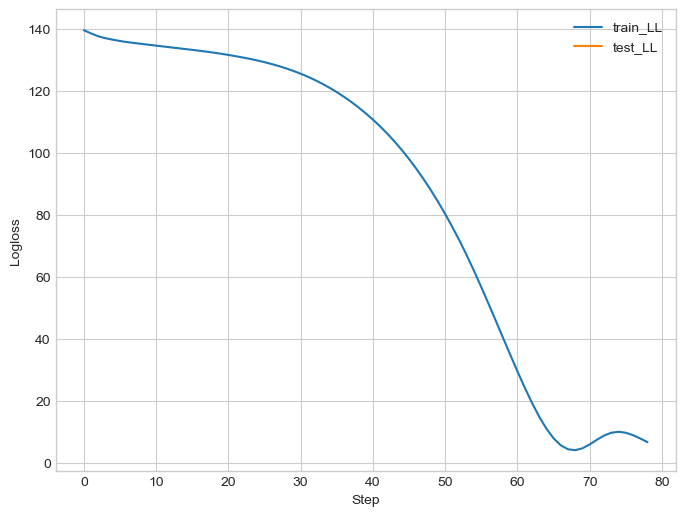

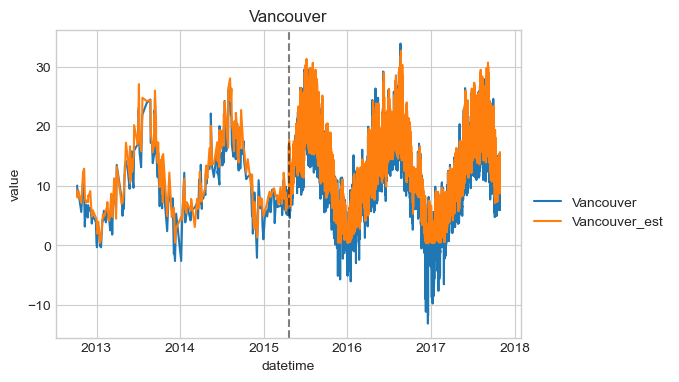

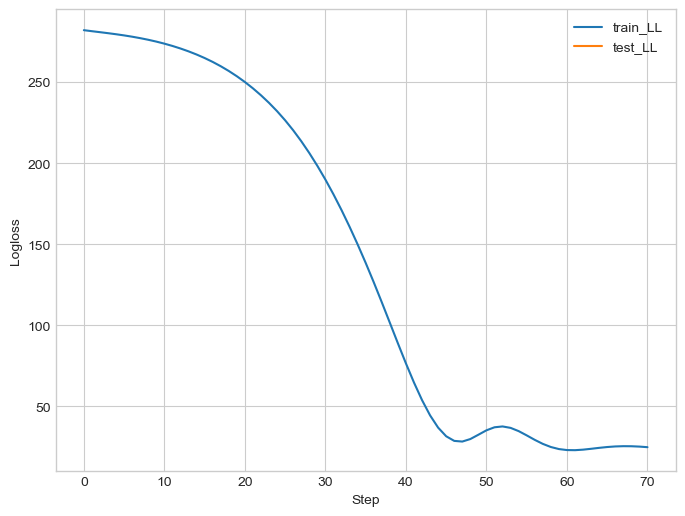

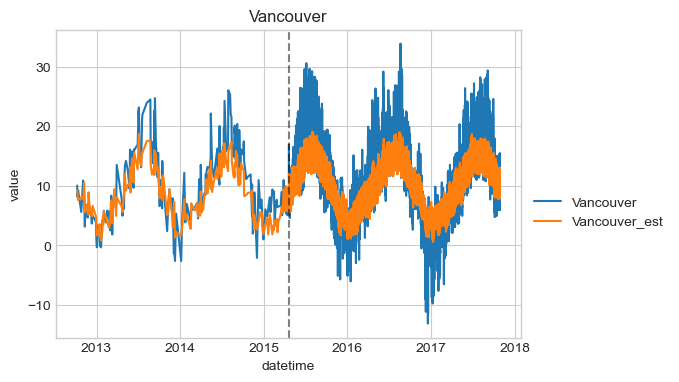

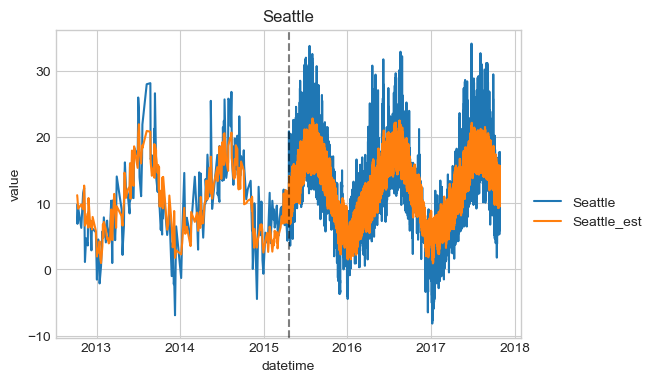

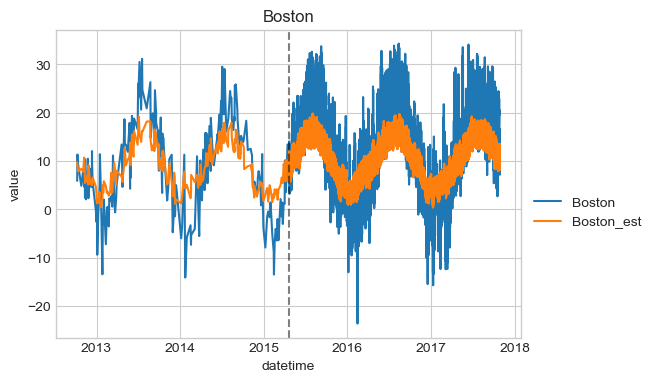

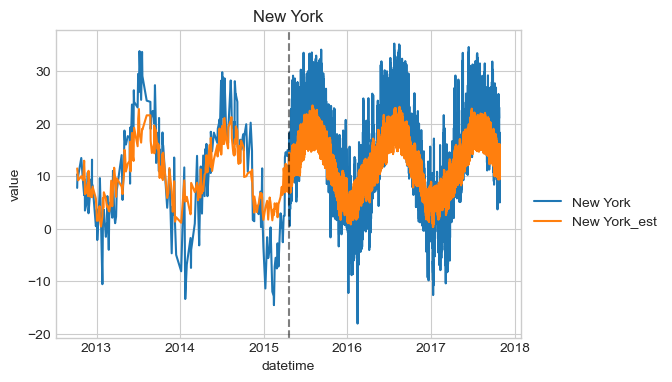

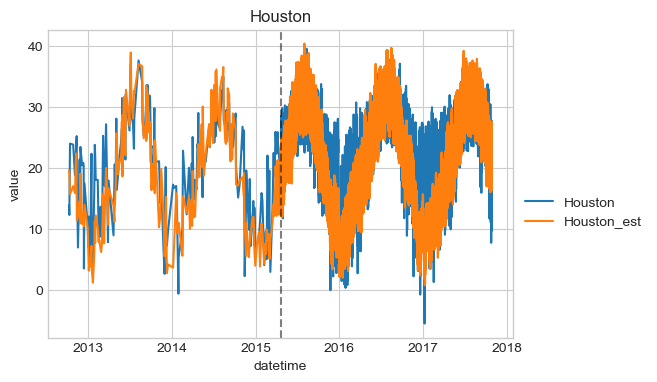

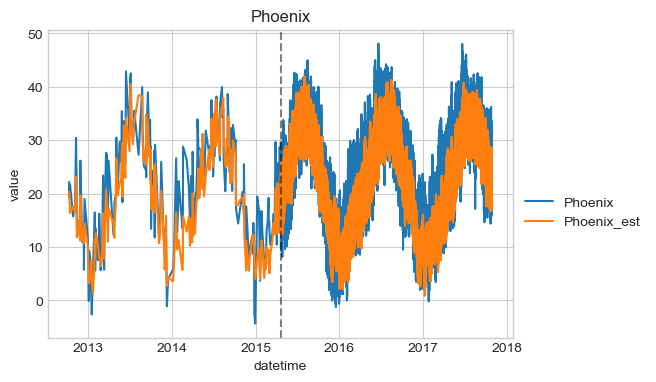

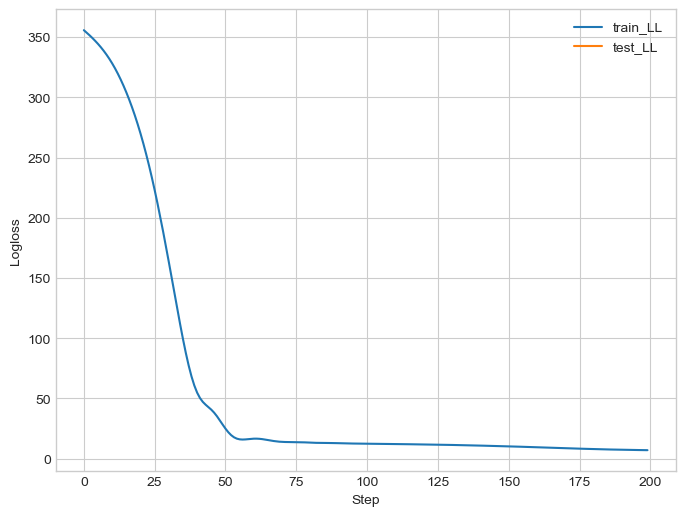

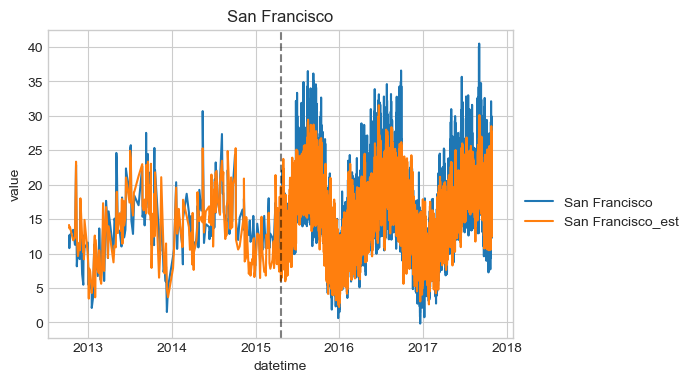

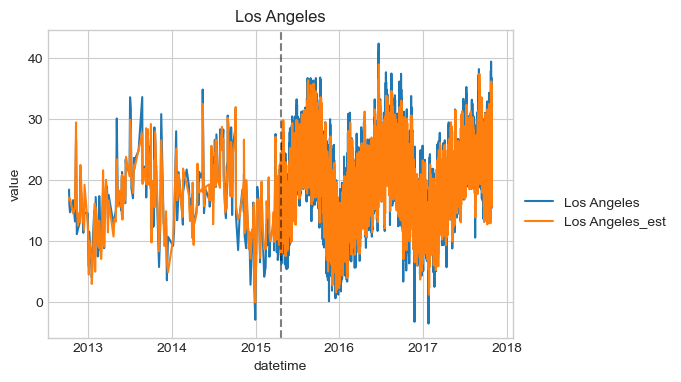

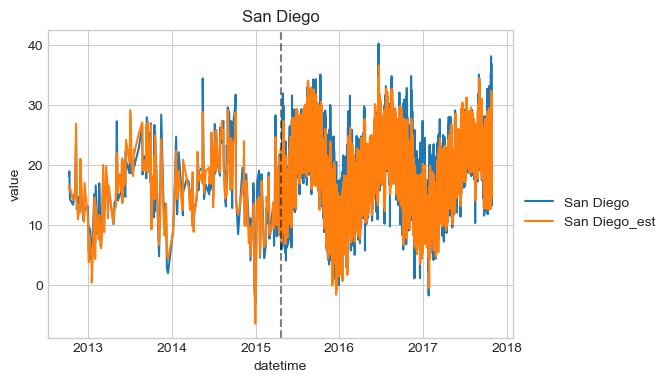

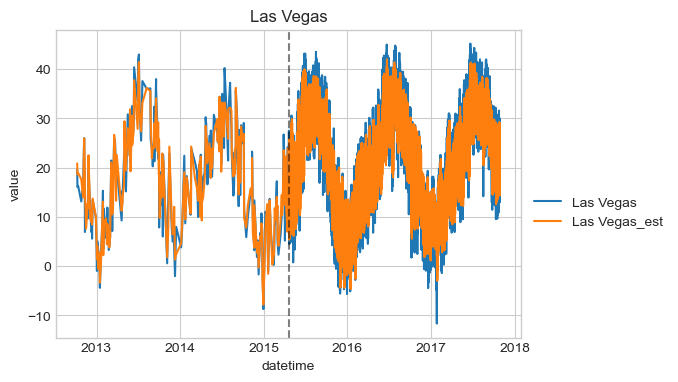

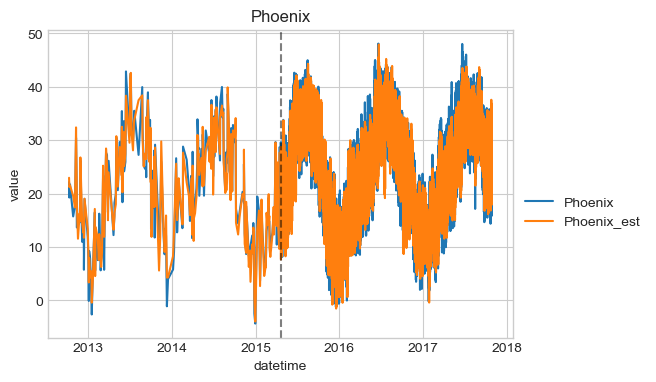

In [10]:
outcome_groups = [
    ["Vancouver"],
    ["Vancouver", "Seattle", "Boston", "New York", "Houston", "Phoenix"],
    df_city_attributes.filter(pl.col('cluster')==2)['City'].to_list(),
]
losses = []
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
        debug=True,
        df=df_lagged,
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses = pl.DataFrame(losses)
losses.sort(["col", "fold", "outcome_cols"])

## Repeated trials

We repeat the trials over a range of training data samples to get a better sense of performance.

Setup all our test cases (5 mins)

In [11]:
outcome_feature_combinations = [
    {
        "outcome_cols": df_city_attributes.filter(pl.col("cluster") == 5)[
            "City"
        ].to_list()[:1],
        "feature_cols": df_city_attributes.filter(pl.col("cluster") == 5)[
            "City"
        ].to_list()[:1],
        "model_name": "single city",
    },
    {
        "outcome_cols": df_city_attributes.filter(pl.col("cluster") == 5)[
            "City"
        ].to_list(),
        "feature_cols": df_city_attributes.filter(pl.col("cluster") == 5)[
            "City"
        ].to_list(),
        "model_name": "cluster cities",
    },
    {
        "outcome_cols": df_city_attributes.filter(pl.col("cluster") == 0)[
            "City"
        ].to_list()[:1],
        "feature_cols": df_city_attributes.filter(pl.col("cluster") == 0)[
            "City"
        ].to_list()[:1],
        "model_name": "single city",
    },
    {
        "outcome_cols": df_city_attributes.filter(pl.col("cluster") == 0)[
            "City"
        ].to_list(),
        "feature_cols": df_city_attributes.filter(pl.col("cluster") == 0)[
            "City"
        ].to_list(),
        "model_name": "cluster cities",
    },
    {
        "outcome_cols": df_city_attributes.group_by("cluster")
        .agg(pl.col("City").first())
        .sort("cluster")["City"]
        .to_list(),
        "feature_cols": df_city_attributes.group_by("cluster")
        .agg(pl.col("City").first())
        .sort("cluster")["City"]
        .to_list(),
        "model_name": "mult-cluster cities",
    },
    {
        "outcome_cols": df_city_attributes["City"].to_list(),
        "feature_cols": df_city_attributes["City"].to_list(),
        "model_name": "all cities",
    },
]

In [12]:
lags = [24, 48, 72, 96]
losses = []
df_lagged = create_lags(df, columns=df.columns[1:], lags=lags)
for seed in range(5):
    print(f"running seed {seed}")

    df_train = df_lagged[: int(df_lagged.shape[0] * 0.5)].sample(fraction=0.1, seed=0)
    df_test = df_lagged[int(df_lagged.shape[0] * 0.5) :]

    for combination in outcome_feature_combinations:
        outcome_cols = combination["outcome_cols"]
        feature_cols = combination["feature_cols"]
        print(f"outcome_cols: {outcome_cols}, feature_cols: {feature_cols}")

        if "callable" not in combination:
            model_callable = lambda feature_cols, outcome_cols: SimpleMLP(
                input_dim=len(feature_cols),
                output_dim=len(outcome_cols),
                learning_rate=1e-3,
            )
        else:
            model_callable = combination["callable"]

        loss_train, loss_test = loss_from_outcomes(
            outcome_cols=outcome_cols,
            feature_cols=get_features_from_outcomes(df_train, feature_cols),
            model_callable=model_callable,
            df_train=df_train,
            df_test=df_test,
            debug=False,
        )

        losses.extend(
            [
                {
                    "model_name": combination["model_name"],
                    "outcome_cols": "_".join(outcome_cols),
                    "feature_cols": "_".join(feature_cols),
                    "seed": seed,
                    "fold": "train",
                    **loss,
                }
                for loss in loss_train
            ]
        )
        losses.extend(
            [
                {
                    "model_name": combination["model_name"],
                    "outcome_cols": "_".join(outcome_cols),
                    "feature_cols": "_".join(feature_cols),
                    "seed": seed,
                    "fold": "test",
                    **loss,
                }
                for loss in loss_test
            ]
        )

losses_repeat_trials = pl.DataFrame(losses)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 0
outcome_cols: ['Vancouver'], feature_cols: ['Vancouver']


/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

outcome_cols: ['Vancouver', 'Portland', 'Seattle'], feature_cols: ['Vancouver', 'Portland', 'Seattle']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City'], feature_cols: ['Kansas City']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami'], feature_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver'], feature_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem'], feature_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 1
outcome_cols: ['Vancouver'], feature_cols: ['Vancouver']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Vancouver', 'Portland', 'Seattle'], feature_cols: ['Vancouver', 'Portland', 'Seattle']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City'], feature_cols: ['Kansas City']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami'], feature_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver'], feature_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem'], feature_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 2
outcome_cols: ['Vancouver'], feature_cols: ['Vancouver']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Vancouver', 'Portland', 'Seattle'], feature_cols: ['Vancouver', 'Portland', 'Seattle']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City'], feature_cols: ['Kansas City']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami'], feature_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver'], feature_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem'], feature_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 3
outcome_cols: ['Vancouver'], feature_cols: ['Vancouver']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Vancouver', 'Portland', 'Seattle'], feature_cols: ['Vancouver', 'Portland', 'Seattle']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City'], feature_cols: ['Kansas City']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami'], feature_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver'], feature_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem'], feature_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 4
outcome_cols: ['Vancouver'], feature_cols: ['Vancouver']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Vancouver', 'Portland', 'Seattle'], feature_cols: ['Vancouver', 'Portland', 'Seattle']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City'], feature_cols: ['Kansas City']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami'], feature_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver'], feature_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem'], feature_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem']


Plot results

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/3596933117.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


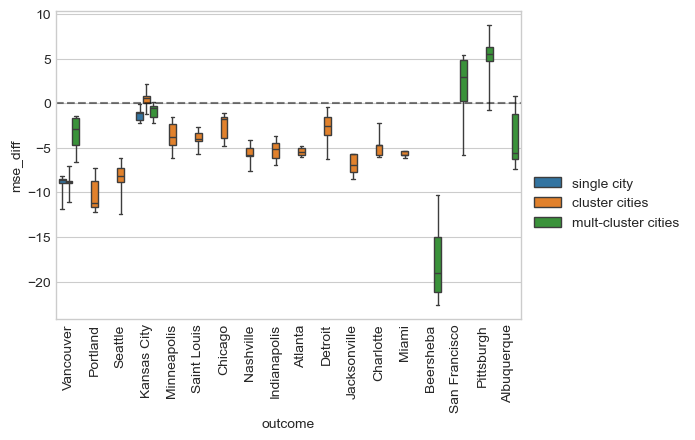

In [13]:
multi_model_cities = (
    losses_repeat_trials.group_by("col")
    .agg(pl.col("model_name").unique().count().alias("count"))
    .filter(pl.col("count") > 1)["col"]
)
plot_df = (
    losses_repeat_trials.filter(
        (pl.col("fold") == "test") & pl.col("col").is_in(multi_model_cities)
    )
    .rename({"col": "outcome"})
    .with_columns(
        (
            pl.col("mse")
            - pl.col("mse").filter(pl.col("model_name") == "all cities").first()
        )
        .over(["outcome", "seed", "fold"])
        .alias("mse_diff")
    )
)

fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(
    data=plot_df.filter(pl.col("model_name") != "all cities"),
    x="outcome",
    y="mse_diff",
    hue="model_name",
    whis=100,
    # gap = 1,
    ax=ax,
)
ax.tick_params(axis="x", labelrotation=90)
ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
ax.axhline(y=0, linestyle="--", color="k", alpha=0.5)
fig.show()

Kansas improves with other cities being present. Most cities are worse off when all cities are trained together.

## Larger data sample

The above results were from training on very small datasets.
Lets repeat the same exercise with larger datasets.
We won't use sampling here, so will be a single pass

In [14]:
lags = [24, 48, 72, 96]
losses = []
df_lagged = create_lags(df, columns=df.columns[1:], lags=lags)
for seed in range(1):
    print(f"running seed {seed}")

    df_train = df_lagged[: int(df_lagged.shape[0] * 0.75)]
    df_test = df_lagged[int(df_lagged.shape[0] * 0.75) :]

    for combination in outcome_feature_combinations:
        outcome_cols = combination["outcome_cols"]
        feature_cols = combination["feature_cols"]
        print(f"outcome_cols: {outcome_cols}, feature_cols: {feature_cols}")

        if "callable" not in combination:
            model_callable = lambda feature_cols, outcome_cols: SimpleMLP(
                input_dim=len(feature_cols),
                output_dim=len(outcome_cols),
                learning_rate=1e-3,
            )
        else:
            model_callable = combination["callable"]

        loss_train, loss_test = loss_from_outcomes(
            outcome_cols=outcome_cols,
            feature_cols=get_features_from_outcomes(df_train, feature_cols),
            model_callable=model_callable,
            df_train=df_train,
            df_test=df_test,
            debug=False,
        )

        losses.extend(
            [
                {
                    "model_name": combination["model_name"],
                    "outcome_cols": "_".join(outcome_cols),
                    "feature_cols": "_".join(feature_cols),
                    "seed": seed,
                    "fold": "train",
                    **loss,
                }
                for loss in loss_train
            ]
        )
        losses.extend(
            [
                {
                    "model_name": combination["model_name"],
                    "outcome_cols": "_".join(outcome_cols),
                    "feature_cols": "_".join(feature_cols),
                    "seed": seed,
                    "fold": "test",
                    **loss,
                }
                for loss in loss_test
            ]
        )

losses_repeat_trials_large = pl.DataFrame(losses)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(


running seed 0
outcome_cols: ['Vancouver'], feature_cols: ['Vancouver']


/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Vancouver', 'Portland', 'Seattle'], feature_cols: ['Vancouver', 'Portland', 'Seattle']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City'], feature_cols: ['Kansas City']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami'], feature_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver'], feature_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem'], feature_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem']


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/642929093.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


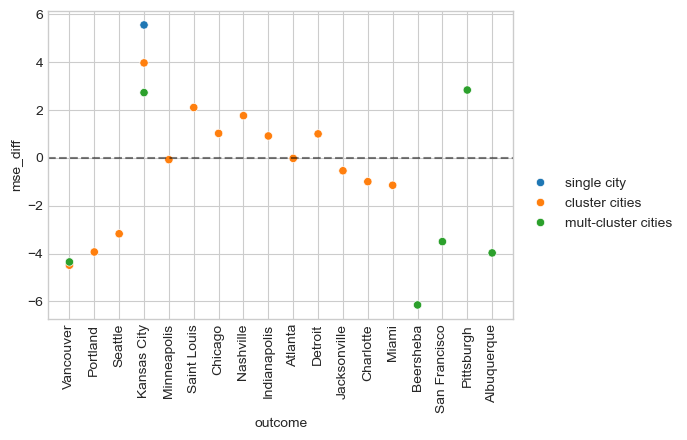

In [15]:
multi_model_cities = (
    losses_repeat_trials_large.group_by("col")
    .agg(pl.col("model_name").unique().count().alias("count"))
    .filter(pl.col("count") > 1)["col"]
)
plot_df = (
    losses_repeat_trials_large.filter(pl.col("col").is_in(multi_model_cities))
    .rename({"col": "outcome"})
    .with_columns(
        (
            pl.col("mse")
            - pl.col("mse").filter(pl.col("model_name") == "all cities").first()
        )
        .over(["outcome", "seed", "fold"])
        .alias("mse_diff")
    )
)

fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=plot_df.filter(
        (pl.col("fold") == "test") & (pl.col("model_name") != "all cities")
    ),
    x="outcome",
    y="mse_diff",
    hue="model_name",
    ax=ax,
)
ax.tick_params(axis="x", labelrotation=90)
ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
ax.axhline(y=0, linestyle="--", color="k", alpha=0.5)
fig.show()

## Larger models

In [16]:
lags = [24, 48, 72, 96]
losses = []
df_lagged = create_lags(df, columns=df.columns[1:], lags=lags)
for seed in range(1):
    print(f"running seed {seed}")

    df_train = df_lagged[: int(df_lagged.shape[0] * 0.75)]
    df_test = df_lagged[int(df_lagged.shape[0] * 0.75) :]

    for combination in outcome_feature_combinations:
        outcome_cols = combination["outcome_cols"]
        feature_cols = combination["feature_cols"]
        print(f"outcome_cols: {outcome_cols}, feature_cols: {feature_cols}")

        if "callable" not in combination:
            model_callable = lambda feature_cols, outcome_cols: SimpleMLP(
                input_dim=len(feature_cols),
                output_dim=len(outcome_cols),
                learning_rate=1e-3,
                hidden_dim=[128, 64, 32, 16],
            )
        else:
            model_callable = combination["callable"]

        loss_train, loss_test = loss_from_outcomes(
            outcome_cols=outcome_cols,
            feature_cols=get_features_from_outcomes(df_train, feature_cols),
            model_callable=model_callable,
            df_train=df_train,
            df_test=df_test,
            debug=False,
        )

        losses.extend(
            [
                {
                    "model_name": combination["model_name"],
                    "outcome_cols": "_".join(outcome_cols),
                    "feature_cols": "_".join(feature_cols),
                    "seed": seed,
                    "fold": "train",
                    **loss,
                }
                for loss in loss_train
            ]
        )
        losses.extend(
            [
                {
                    "model_name": combination["model_name"],
                    "outcome_cols": "_".join(outcome_cols),
                    "feature_cols": "_".join(feature_cols),
                    "seed": seed,
                    "fold": "test",
                    **loss,
                }
                for loss in loss_test
            ]
        )

losses_repeat_trials_large_models = pl.DataFrame(losses)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (33) is 

running seed 0
outcome_cols: ['Vancouver'], feature_cols: ['Vancouver']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Vancouver', 'Portland', 'Seattle'], feature_cols: ['Vancouver', 'Portland', 'Seattle']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City'], feature_cols: ['Kansas City']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami'], feature_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver'], feature_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem'], feature_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem']


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/1317863779.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


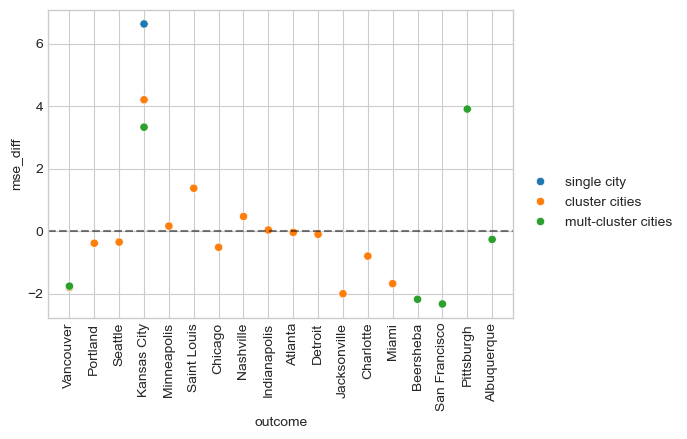

In [17]:
multi_model_cities = (
    losses_repeat_trials_large_models.group_by("col")
    .agg(pl.col("model_name").unique().count().alias("count"))
    .filter(pl.col("count") > 1)["col"]
)
plot_df = (
    losses_repeat_trials_large_models.filter(
        (pl.col("fold") == "test") & pl.col("col").is_in(multi_model_cities)
    )
    .rename({"col": "outcome"})
    .with_columns(
        (
            pl.col("mse")
            - pl.col("mse").filter(pl.col("model_name") == "all cities").first()
        )
        .over(["outcome", "seed", "fold"])
        .alias("mse_diff")
    )
)

fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=plot_df.filter(pl.col("model_name") != "all cities"),
    x="outcome",
    y="mse_diff",
    hue="model_name",
    ax=ax,
)
ax.tick_params(axis="x", labelrotation=90)
ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
ax.axhline(y=0, linestyle="--", color="k", alpha=0.5)
fig.show()

## Even larger models

In [18]:
lags = [24, 48, 72, 96]
losses = []
df_lagged = create_lags(df, columns=df.columns[1:], lags=lags)
for seed in range(1):
    print(f"running seed {seed}")

    df_train = df_lagged[: int(df_lagged.shape[0] * 0.75)]
    df_test = df_lagged[int(df_lagged.shape[0] * 0.75) :]

    for combination in outcome_feature_combinations:
        outcome_cols = combination["outcome_cols"]
        feature_cols = combination["feature_cols"]
        print(f"outcome_cols: {outcome_cols}, feature_cols: {feature_cols}")

        if "callable" not in combination:
            model_callable = lambda feature_cols, outcome_cols: SimpleMLP(
                input_dim=len(feature_cols),
                output_dim=len(outcome_cols),
                learning_rate=1e-3,
                hidden_dim=[128, 128, 128, 128],
            )
        else:
            model_callable = combination["callable"]

        loss_train, loss_test = loss_from_outcomes(
            outcome_cols=outcome_cols,
            feature_cols=get_features_from_outcomes(df_train, feature_cols),
            model_callable=model_callable,
            df_train=df_train,
            df_test=df_test,
            debug=False,
        )

        losses.extend(
            [
                {
                    "model_name": combination["model_name"],
                    "outcome_cols": "_".join(outcome_cols),
                    "feature_cols": "_".join(feature_cols),
                    "seed": seed,
                    "fold": "train",
                    **loss,
                }
                for loss in loss_train
            ]
        )
        losses.extend(
            [
                {
                    "model_name": combination["model_name"],
                    "outcome_cols": "_".join(outcome_cols),
                    "feature_cols": "_".join(feature_cols),
                    "seed": seed,
                    "fold": "test",
                    **loss,
                }
                for loss in loss_test
            ]
        )

losses_repeat_trials_large_models = pl.DataFrame(losses)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 0
outcome_cols: ['Vancouver'], feature_cols: ['Vancouver']


/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch

outcome_cols: ['Vancouver', 'Portland', 'Seattle'], feature_cols: ['Vancouver', 'Portland', 'Seattle']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City'], feature_cols: ['Kansas City']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami'], feature_cols: ['Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver'], feature_cols: ['Kansas City', 'Beersheba', 'San Francisco', 'Pittsburgh', 'Albuquerque', 'Vancouver']


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem'], feature_cols: ['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya', 'Jerusalem']


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_32471/1317863779.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


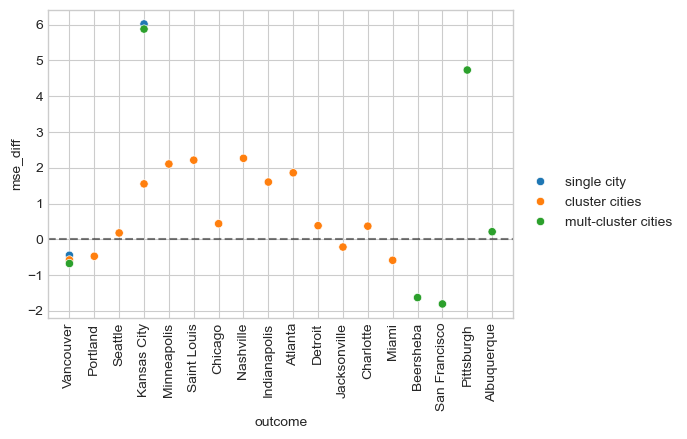

In [19]:
multi_model_cities = (
    losses_repeat_trials_large_models.group_by("col")
    .agg(pl.col("model_name").unique().count().alias("count"))
    .filter(pl.col("count") > 1)["col"]
)
plot_df = (
    losses_repeat_trials_large_models.filter(
        (pl.col("fold") == "test") & pl.col("col").is_in(multi_model_cities)
    )
    .rename({"col": "outcome"})
    .with_columns(
        (
            pl.col("mse")
            - pl.col("mse").filter(pl.col("model_name") == "all cities").first()
        )
        .over(["outcome", "seed", "fold"])
        .alias("mse_diff")
    )
)

fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=plot_df.filter(pl.col("model_name") != "all cities"),
    x="outcome",
    y="mse_diff",
    hue="model_name",
    ax=ax,
)
ax.tick_params(axis="x", labelrotation=90)
ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
ax.axhline(y=0, linestyle="--", color="k", alpha=0.5)
fig.show()

# Appendix

Todo:

1. Using small data is unlikely the right approach
   1. Multiple outcomes will help prevent overfit
2. Using large datasets where the single outcome performance plateaus, then inserting other tasks to improve it.
3. Use clusters to split multi head outputs
4. Single cities are a subset of the all cities data space, so we should be able to get equivalent performance with enough model capacity and data.
5. Multi output head for large data/models

In [20]:
raise NotImplementedError

NotImplementedError: 